## Risk Parity backtest

This notebook follows the 06a-backtest example and implements risk-parity weighting in addition to equal-weighting.

In [2]:
from sqlalchemy import create_engine
!pip install pymssql
!pip install scikit-learn
import pymssql
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = LinearRegression()
qt = QuantileTransformer(output_distribution="normal")
poly = PolynomialFeatures(degree=2)
pipe = make_pipeline(poly, model)


[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
dfbase = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + dfbase
conn = create_engine(string).connect()

#### Get data

In [4]:
df = pd.read_sql(
    """
    select ticker, date, ret, roeq, bm, mom12m, mve
    from data
    where date>='2000-01'
    order by date, ticker
    """, 
    conn
)
df = df.dropna()
conn.close()


In [ ]:
raw_data = df.copy()
raw_data = raw_data.reset_index()

In [ ]:
features = ["roeq", "bm", "mom12m"]


In [26]:
raw_data.xs('IBM', level='ticker', drop_level=False)
raw_data.xs('2000-01', level='date', drop_level=False)

ret      roeq        bm    mom12m        mve
date    ticker                                                   
2000-01 AA     -0.160392  0.039969  0.438760  0.783092  17.230341
        AABC   -0.029528  0.054207  1.107577  0.077586   9.194465
        AAC     0.056338  0.053986  1.893766  0.241379  12.072728
        AACE   -0.067568  0.049065  0.339860  0.095833  12.134491
        AAG    -0.100694  0.028019  0.703278 -0.294565  13.544615
...                  ...       ...       ...       ...        ...
        ZOMX   -0.005525  0.094583  0.428749  3.557692  13.459701
        ZONA    0.771429 -0.078612  0.249106 -0.715686  10.805451
        ZQK    -0.217742  0.041841  0.397946 -0.243750  12.770872
        ZRAN   -0.181614  0.033529  0.202465  1.278572  13.572464
        ZVXI    0.926829  0.014941  1.241130  0.052632   9.771819

[5063 rows x 5 columns]

### Estimate expanding window volatilities each month

In [87]:
WINDOW = 60

In [95]:
df = raw_data.set_index(['ticker','date']).sort_values(by=['ticker','date'])
df_wide = df.ret.unstack(level=0)
sds = df_wide.expanding(WINDOW).std()
sds = sds.stack()
sds = sds.swaplevel().sort_index()
sds.name = 'sd'
sds

ticker  date   
A       2007-03    0.128052
        2007-04    0.126989
        2007-05    0.126610
        2007-06    0.125585
        2007-07    0.124604
                     ...   
ZVXI    2021-11    0.273161
        2021-12    0.273161
        2022-01    0.273161
        2022-02    0.273161
        2022-03    0.273161
Name: sd, Length: 928365, dtype: float64

In [96]:
sds.xs('IBM',level='ticker', drop_level=False)

ticker  date   
IBM     2004-12    0.103784
        2005-01    0.103169
        2005-02    0.102328
        2005-03    0.101519
        2005-04    0.102848
                     ...   
        2021-11    0.071878
        2021-12    0.072231
        2022-01    0.072095
        2022-02    0.072109
        2022-03    0.072056
Name: sd, Length: 208, dtype: float64

#### Drop largest 500 stocks each month

In [97]:
df = raw_data.set_index(["date", "ticker"]).copy()

In [98]:
df["size_rnk"] = df.groupby("date").mve.rank(ascending=False)
df = df[df.size_rnk>500]

#### Transform features each month

In [99]:
def qt_df(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[features] = df.groupby("date", group_keys=False)[features].apply(qt_df)

#### Transform target each month

In [100]:
def qt_ser(s):
    x = s.copy()
    x = x.to_numpy().reshape(-1, 1)
    x = qt.fit_transform(x).flatten()
    return pd.Series(x, index=s.index)

df["target"] = df.groupby("date", group_keys=False).ret.apply(qt_ser)

#### Train and predict in a loop

In [101]:
predictions = None

dates = ["2005-01", "2010-01", "2015-01", "2020-01", "3000-01"]
for train_date, end_date in zip(dates[:-1], dates[1:]):

    filter1 = df.index.get_level_values("date") < train_date
    filter2 = df.index.get_level_values("date") < end_date

    train = df[filter1]
    test = df[~filter1 & filter2]

    Xtrain = train[features]
    ytrain = train["target"]
    Xtest = test[features]

    pipe.fit(Xtrain, ytrain)
    pred = pipe.predict(Xtest)
    pred = pd.Series(pred, index=test.index)
    predictions = pd.concat((predictions, pred))

df["predict"] = predictions

#### Merge in volatilities

In [102]:
df = pd.merge(df, sds.swaplevel(), left_index=True, right_index=True)
df

ret      roeq        bm    mom12m        mve  size_rnk  \
date    ticker                                                                
2004-12 AACE    0.111903  0.012259  0.686011  0.846174  12.790238    2047.0   
        AAII    0.051780  2.097185 -1.435987 -2.726759  11.388843    3170.0   
        AAME    0.033333 -0.282913  1.728346  0.298846  11.058055    3391.0   
        AANB    0.180442  0.505941 -0.247464  0.093628  10.909255    3491.0   
        AAON    0.009422  0.061443 -0.674471 -0.720448  12.193995    2534.0   
...                  ...       ...       ...       ...        ...       ...   
2022-03 YELP    0.006492 -0.008022 -0.296959 -0.173110  14.721554    1002.0   
        YORW    0.002229  0.344067 -0.624169  0.384817  13.285281    1535.0   
        YTEN    0.261905 -1.262128  0.071652 -1.837949   9.928395    2311.0   
        ZEUS    0.436683  1.467827  1.924874  0.666564  12.604142    1728.0   
        ZUMZ   -0.141155  0.598113  0.083015  0.054865  13.757728    1370.0   

                  target   predict        sd  
date    ticker                                
2004-12 AACE    0.725076       NaN  0.116874  
        AAII    0.222377       NaN  0.245369  
        AAME    0.003373       NaN  0.121825  
        AANB    1.162363       NaN  0.079512  
        AAON   -0.342627       NaN  0.113154  
...                  ...       ...       ...  
2022-03 YELP    0.143844  0.036309  0.147324  
        YORW    0.091432  0.056389  0.061721  
        YTEN    1.597743 -0.169210  0.310849  
        ZEUS    2.168410  0.130236  0.178060  
        ZUMZ   -1.378972  0.072304  0.157737  

[430757 rows x 9 columns]

#### Lag volatility 

In [114]:
df['lag_sd'] = df.groupby(level=1).sd.shift(1)
df.xs('YELP',level='ticker', drop_level=False).head()

,,ret,roeq,bm,mom12m,mve,size_rnk,target,predict,sd,lag_sd,inverse_var
date,ticker,,,,,,,,,,,
2019-05,YELP,-0.232901,-0.092168,-0.396406,-0.581662,15.005158,823.0,-1.145476,0.008860,0.147527,NaN,NaN
2019-06,YELP,0.112268,0.442784,-0.395686,0.082686,14.680300,929.0,0.642551,0.052772,0.147019,0.147527,45.946755
2019-07,YELP,0.025453,0.441471,-0.400773,-0.179907,14.786702,918.0,0.356582,0.046187,0.145845,0.147019,46.264752
2019-08,YELP,-0.043937,0.447650,-0.402128,0.201198,14.811837,908.0,0.121159,0.054795,0.144772,0.145845,47.012927
2019-09,YELP,0.037004,-0.260449,-0.407563,-0.404116,14.682673,932.0,0.046494,0.007121,0.143694,0.144772,47.712104


In [113]:
df['inverse_var'] = 1/(df.lag_sd**2)
df.xs('YELP',level='ticker', drop_level=False).head()

,,ret,roeq,bm,mom12m,mve,size_rnk,target,predict,sd,lag_sd,inverse_var
date,ticker,,,,,,,,,,,
2019-05,YELP,-0.232901,-0.092168,-0.396406,-0.581662,15.005158,823.0,-1.145476,0.008860,0.147527,NaN,NaN
2019-06,YELP,0.112268,0.442784,-0.395686,0.082686,14.680300,929.0,0.642551,0.052772,0.147019,0.147527,45.946755
2019-07,YELP,0.025453,0.441471,-0.400773,-0.179907,14.786702,918.0,0.356582,0.046187,0.145845,0.147019,46.264752
2019-08,YELP,-0.043937,0.447650,-0.402128,0.201198,14.811837,908.0,0.121159,0.054795,0.144772,0.145845,47.012927
2019-09,YELP,0.037004,-0.260449,-0.407563,-0.404116,14.682673,932.0,0.046494,0.007121,0.143694,0.144772,47.712104


#### Compute returns of portfolios of best and worst stocks

In [146]:
df = df.dropna(subset=["predict"])

numstocks = 100

df["rnk"] = df.groupby("date").predict.rank(method="first", ascending=False)
best = df[df.rnk<=numstocks]

df["rnk"] = df.groupby("date").predict.rank(method="first")
worst = df[df.rnk<=numstocks]

In [132]:
worst.head()

ret      roeq        bm    mom12m        mve  size_rnk  \
date    ticker                                                                
2005-01 AAII   -0.178462  2.118992 -1.437618 -3.087117  11.439327    3186.0   
        ABFI   -0.466667 -2.880181  0.766901 -0.567059   8.370455    4236.0   
        ACEC    0.291667 -1.874422 -1.156635 -0.574120  10.407385    3818.0   
        ACR     0.064461 -2.059313 -1.859203  2.011144  12.608771    2237.0   
        AICX    0.090909 -2.127976 -1.084324 -2.235167   9.441300    4132.0   

                  target   predict        sd    lag_sd  inverse_var   rnk  
date    ticker                                                             
2005-01 AAII   -1.292443 -0.176312  0.244647  0.245369    16.609714  83.0  
        ABFI   -2.840673 -0.273414  0.249967  0.244860    16.678775  12.0  
        ACEC    2.191251 -0.169931  0.347926  0.349213     8.200097  91.0  
        ACR     1.112948 -0.267857  0.213641  0.215392    21.554619  16.0  
        AICX    1.321948 -0.276635  0.365792  0.368810     7.351819  11.0

#### Equal-weighted returns

In [133]:
best_rets  = best.groupby("date").ret.mean()
worst_rets = worst.groupby("date").ret.mean()
rets = pd.concat((best_rets, worst_rets), axis=1)
rets.columns = ["best", "worst"]
rets.head()
# rets.to_csv("files/rets.csv")


,best,worst
date,,
2005-01,-0.005356,-0.081827
2005-02,0.041530,-0.074315
2005-03,-0.048466,-0.089032
2005-04,-0.061057,-0.105959
2005-05,0.051723,0.043296


#### Risk-parity returns

In [147]:
best

ret      roeq        bm    mom12m        mve  size_rnk  \
date    ticker                                                                
2005-01 ABL     0.052632  1.182907  1.628030  1.130569  10.577421    3731.0   
        ACAS    0.019490  1.338645  0.419595  0.286749  14.900129     626.0   
        AGII    0.013725  0.389729  1.641080  0.577761  13.280026    1721.0   
        ALDA   -0.072787  1.483048  1.812573  2.518106  11.266855    3301.0   
        ALG    -0.033137  0.426933  1.259061  0.823644  12.485536    2336.0   
...                  ...       ...       ...       ...        ...       ...   
2022-03 VIA    -0.260987  1.335621 -0.000832  0.692222  12.069410    1858.0   
        VIRC   -0.006645  1.091610  1.286850 -0.051664  10.788639    2191.0   
        WSBF   -0.010235  0.660527  0.661027  0.535450  13.067852    1602.0   
        X       0.386990  1.981783  0.925956  0.871628  15.775596     586.0   
        ZEUS    0.436683  1.467827  1.924874  0.666564  12.604142    1728.0   

                  target   predict        sd    lag_sd  inverse_var    rnk  
date    ticker                                                              
2005-01 ABL     1.008471  0.170241  0.096840  0.097448   105.306743    6.0  
        ACAS    0.695581  0.116341  0.079592  0.080264   155.225159   93.0  
        AGII    0.631787  0.127166  0.104596  0.105478    89.882681   63.0  
        ALDA   -0.478855  0.150051  0.193612  0.194712    26.376371   25.0  
        ALG    -0.015578  0.116249  0.069438  0.069686   205.926709   94.0  
...                  ...       ...       ...       ...          ...    ...  
2022-03 VIA    -2.049083  0.087820  0.093421  0.090719   121.508051  100.0  
        VIRC   -0.024321  0.103784  0.128988  0.129351    59.767118   18.0  
        WSBF   -0.063724  0.090299  0.130029  0.130415    58.795838   75.0  
        X       1.985105  0.109824  0.177038  0.175901    32.319572   12.0  
        ZEUS    2.168410  0.130236  0.178060  0.176567    32.076151    3.0  

[20700 rows x 12 columns]

In [148]:
sum_inverse_var = best.groupby('date').inverse_var.sum()
sum_inverse_var.name = 'sum_inverse_var'
sum_inverse_var

date
2005-01    5611.806555
2005-02    6029.050128
2005-03    5454.688393
2005-04    5507.294438
2005-05    5981.954414
              ...     
2021-11    9222.628044
2021-12    7705.782159
2022-01    7348.069793
2022-02    8236.535117
2022-03    7600.272952
Name: sum_inverse_var, Length: 207, dtype: float64

In [149]:
best = best.reset_index().merge(sum_inverse_var,left_on='date',right_on='date')
best.head()

,date,ticker,ret,roeq,bm,mom12m,mve,size_rnk,target,predict,sd,lag_sd,inverse_var,rnk,sum_inverse_var
0,2005-01,ABL,0.052632,1.182907,1.628030,1.130569,10.577421,3731.0,1.008471,0.170241,0.096840,0.097448,105.306743,6.0,5611.806555
1,2005-01,ACAS,0.019490,1.338645,0.419595,0.286749,14.900129,626.0,0.695581,0.116341,0.079592,0.080264,155.225159,93.0,5611.806555
2,2005-01,AGII,0.013725,0.389729,1.641080,0.577761,13.280026,1721.0,0.631787,0.127166,0.104596,0.105478,89.882681,63.0,5611.806555
3,2005-01,ALDA,-0.072787,1.483048,1.812573,2.518106,11.266855,3301.0,-0.478855,0.150051,0.193612,0.194712,26.376371,25.0,5611.806555
4,2005-01,ALG,-0.033137,0.426933,1.259061,0.823644,12.485536,2336.0,-0.015578,0.116249,0.069438,0.069686,205.926709,94.0,5611.806555


In [153]:
best['wgt'] = best.inverse_var/best.sum_inverse_var
best['wgt_x_ret'] = best.wgt * best.ret
best_rets = best.groupby("date").wgt_x_ret.sum()

Same for worst

In [154]:
sum_inverse_var = worst.groupby('date').inverse_var.sum()
sum_inverse_var.name = 'sum_inverse_var'
worst = worst.reset_index().merge(sum_inverse_var,left_on='date',right_on='date')
worst['wgt'] = worst.inverse_var/worst.sum_inverse_var
worst['wgt_x_ret'] = worst.wgt * worst.ret
worst_rets = worst.groupby("date").wgt_x_ret.sum()

In [156]:
rets_risk_parity = pd.concat((best_rets, worst_rets), axis=1)
rets_risk_parity.columns = ["best", "worst"]
rets_risk_parity.head()

,best,worst
date,,
2005-01,0.009367,-0.069581
2005-02,0.045342,-0.051452
2005-03,-0.043387,-0.062486
2005-04,-0.044839,-0.071012
2005-05,0.053237,0.039750


In [162]:
print(f'Equal-weighted')
print(f'Best: average return:\t {rets.best.mean(): .4f}')
print(f'Best: SD(return):\t {rets.best.std(): .4f}')
print(f'Worst: average return:\t {rets.worst.mean(): .4f}')
print(f'Worst: SD(return):\t {rets.worst.std(): .4f}')

print(f'\nRisk parity')
print(f'Best: average return:\t {rets_risk_parity.best.mean(): .4f}')
print(f'Best: SD(return):\t {rets_risk_parity.best.std(): .4f}')
print(f'Worst: average return:\t {rets_risk_parity.worst.mean(): .4f}')
print(f'Worst: SD(return):\t {rets_risk_parity.worst.std(): .4f}')



Equal-weighted
Best: average return:	  0.0134
Best: SD(return):	  0.0552
Worst: average return:	  0.0134
Worst: SD(return):	  0.1142

Risk parity
Best: average return:	  0.0118
Best: SD(return):	  0.0453
Worst: average return:	  0.0144
Worst: SD(return):	  0.1117


# Performance evaluation

In [171]:
from pandas_datareader import DataReader as pdr
ff = pdr("F-F_Research_Data_5_Factors_2x3", "famafrench", start=2005)[0]/100

In [177]:
rets.index = pd.to_datetime(rets.index).to_period("M")
rets["mkt"] = ff["Mkt-RF"] + ff["RF"]
rets["ls"] = 1.3*rets["best"] - 0.3*rets["worst"]
rets["rf"] = ff["RF"]

In [185]:
rets_risk_parity.index = pd.to_datetime(rets_risk_parity.index).to_period("M")
rets_risk_parity["mkt"] = ff["Mkt-RF"] + ff["RF"]
rets_risk_parity["ls"] = 1.3*rets_risk_parity["best"] - 0.3*rets_risk_parity["worst"]
rets_risk_parity["rf"] = ff["RF"]

Accumulations

<AxesSubplot:xlabel='date'>

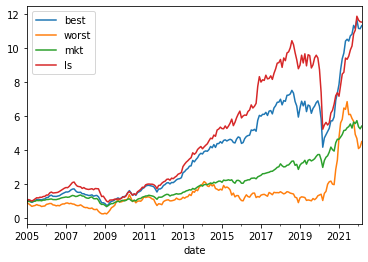

In [184]:
(1+rets[["best", "worst", "mkt", "ls"]]).cumprod().plot()

<AxesSubplot:xlabel='date'>

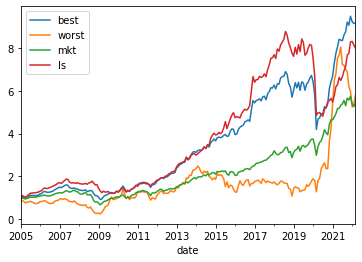

In [186]:
(1+rets_risk_parity[["best", "worst", "mkt", "ls"]]).cumprod().plot()

Excess returns and Sharpe ratios

In [188]:
xrets = rets[["best", "worst", "mkt", "ls"]].subtract(rets.rf, axis=0)
sharpes = np.sqrt(12)*xrets.mean()/xrets.std()
sharpes.round(4)

best     0.7764
worst    0.3780
mkt      0.6513
ls       0.8078
dtype: float64

In [189]:
xrets = rets_risk_parity[["best", "worst", "mkt", "ls"]].subtract(rets_risk_parity.rf, axis=0)
sharpes = np.sqrt(12)*xrets.mean()/xrets.std()
sharpes.round(4)

best     0.8294
worst    0.4152
mkt      0.6513
ls       0.8076
dtype: float64

130/30 drawdowns

In [191]:
import matplotlib.pyplot as plt

Text(0, 0.5, ' % Drawdown')

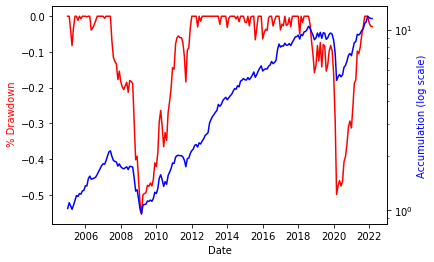

In [192]:
ls = (1+rets.ls).cumprod()
lsmax = ls.expanding().max()
drawdown = ls/lsmax - 1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.set_yscale("log")
ax2.plot(rets.index.to_timestamp(), ls, 'b-')
ax1.plot(rets.index.to_timestamp(), drawdown, 'r-')

ax1.set_xlabel('Date')
ax2.set_ylabel('Accumulation (log scale)', color='b')
ax1.set_ylabel(' % Drawdown', color='r')

Text(0, 0.5, ' % Drawdown')

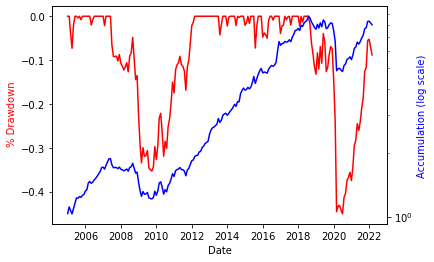

In [193]:
ls = (1+rets_risk_parity.ls).cumprod()
lsmax = ls.expanding().max()
drawdown = ls/lsmax - 1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.set_yscale("log")
ax2.plot(rets_risk_parity.index.to_timestamp(), ls, 'b-')
ax1.plot(rets_risk_parity.index.to_timestamp(), drawdown, 'r-')

ax1.set_xlabel('Date')
ax2.set_ylabel('Accumulation (log scale)', color='b')
ax1.set_ylabel(' % Drawdown', color='r')